In [1]:
import pandas as pd
import numpy as np


In [109]:
loandata = pd.read_csv('../loan_data_inputs_train.csv',index_col=0)

In [3]:
loandata_backup = loandata.copy()  

In [4]:
loandata

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,A,...,1,0,0,1,0,0,0,0,0,0
206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,C,...,0,0,0,1,0,0,0,0,0,0
136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,A,...,0,0,0,1,0,0,0,0,0,0
412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,D,...,0,0,0,1,0,0,0,0,0,0
36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,C,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,259178,34392215,37055507,5000,5000,5000.0,36 months,8.67,158.24,B,...,0,0,0,0,0,0,0,1,0,0
365838,365838,19345890,21548652,20000,20000,20000.0,36 months,12.49,668.98,B,...,0,0,0,1,0,0,0,0,0,0
131932,131932,5145550,6467765,19200,19200,19175.0,36 months,14.09,657.06,B,...,0,0,0,1,0,0,0,0,0,0
146867,146867,4374922,5607101,15500,15500,15500.0,36 months,11.14,508.48,B,...,0,1,0,1,0,0,0,0,0,0


In [106]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']
# List of all independent variables for the models.

In [107]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [113]:
lgd_inputs_stage_1_train = loandata[features_all]

In [117]:
lgd_targets_stage_1_train = pd.read_csv('../loan_data_targets_train.csv',index_col=0)
lgd_targets_stage_1_train

,good_bad
427211,1
206088,1
136020,1
412305,0
36159,0
...,...
259178,1
365838,1
131932,1
146867,1


In [9]:
lgd_inputs_stage_1_train.fillna(0, inplace=True)

/tmp/ipykernel_10110/902343434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lgd_inputs_stage_1_train.fillna(0, inplace=True)


In [104]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

class SklearnLogitWithP:
    def __init__(self, *args, **kwargs):
        # Default parameters for stable fitting
        if 'penalty' not in kwargs:
            kwargs['penalty'] = 'none'
        if 'max_iter' not in kwargs:
            kwargs['max_iter'] = 2000

        self.model = LogisticRegression(*args, **kwargs)

        # Track which columns are dropped at different stages
        self.dropped_columns = {
            "constant_or_zero_variance": [],
            "duplicate": [],
            "near_singular": []
        }

    def _to_dataframe(self, X):
        """Ensure the data is a pandas DataFrame with column names."""
        if isinstance(X, pd.DataFrame):
            return X.copy()
        elif isinstance(X, pd.Series):
            return X.to_frame()
        else:
            return pd.DataFrame(X, columns=[f"x{i}" for i in range(np.shape(X)[1])])

    def _convert_bool(self, X):
        """Convert boolean data to float type."""
        if isinstance(X, (pd.DataFrame, pd.Series)):
            return X.astype(float)
        return pd.DataFrame(X).astype(float)

    def _clean_X(self, X):
        """Clean input features: remove zero-variance and duplicate columns."""
        X = self._to_dataframe(X)

        # Drop zero variance columns
        zero_var_cols = X.columns[X.std() == 0].tolist()
        if zero_var_cols:
            self.dropped_columns["constant_or_zero_variance"].extend(zero_var_cols)
            X = X.drop(columns=zero_var_cols, errors='ignore')

        # Drop duplicate columns
        duplicate_cols = X.columns[X.columns.duplicated()].tolist()
        if duplicate_cols:
            self.dropped_columns["duplicate"].extend(duplicate_cols)
            X = X.loc[:, ~X.columns.duplicated()]

        # Add constant if not already present
        if 'const' not in X.columns:
            X = sm.add_constant(X, has_constant='add')

        return X

    def fit(self, X, y):
        """Fit both sklearn and statsmodels versions to get p-values."""
        X = self._convert_bool(X)
        y = self._convert_bool(y).squeeze()

        # Fit sklearn logistic regression
        self.model.fit(X, y)

        # Prepare data for statsmodels
        X_const = self._clean_X(X)

        try:
            sm_model = sm.Logit(y, X_const).fit(disp=False)
        except np.linalg.LinAlgError:
            # Handle near-singular matrix by dropping highly correlated columns
            X_const = self._to_dataframe(X_const)
            corr_matrix = X_const.corr().abs()
            corr_sum = corr_matrix.sum()
            keep_cols = corr_sum[corr_sum < X_const.shape[1]].index
            dropped_cols = set(X_const.columns) - set(keep_cols)
            X_const = X_const[keep_cols]
            self.dropped_columns["near_singular"] = list(dropped_cols)
            sm_model = sm.Logit(y, X_const).fit(disp=False)

        # Track the final columns used in the statsmodels regression
        X_const = self._to_dataframe(X_const)
        self.final_columns = list(X_const.columns)

        # Store results
        self.p_values = sm_model.pvalues
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.std_err = sm_model.bse
        self.z_scores = sm_model.tvalues
        self.result = sm_model

        return self

    def summary(self):
        """Print the statsmodels regression summary."""
        if hasattr(self, 'result'):
            print(self.result.summary())
        else:
            print("Model not fitted yet. Please call .fit() first.")


In [ ]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat,axis=1)

KeyError: "['grade:G', 'home_ownership:RENT', 'verification_status:Verified', 'purpose:credit_card', 'initial_list_status:f'] not found in axis"

In [121]:

lgd_inputs_stage_1_train.fillna(0, inplace=True)

In [122]:
reg_lgd_st_1 = SklearnLogitWithP()
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

/home/aaron/anaconda3/envs/Universal/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [116]:
feature_name = lgd_inputs_stage_1_train.columns.values
feature_name

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [14]:
reg_lgd_st_1.dropped_columns

{'constant_or_zero_variance': [], 'duplicate': [], 'near_singular': []}

In [15]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()

In [16]:
summary_table

,Feature name,Coefficients
0,Intercept,0.009254
1,grade:A,0.012607
2,grade:B,0.013195
3,grade:C,0.002114
4,grade:D,-0.006047
5,grade:E,-0.006915
6,grade:F,-0.004401
7,home_ownership:MORTGAGE,0.004919
8,home_ownership:NONE,-0.000006
9,home_ownership:OTHER,-0.000023


In [17]:

p_values = reg_lgd_st_1.p_values    
summary_table['p_values']=summary_table['Feature name'].map(p_values)
p_values

const                                   0.000000e+00
grade:A                                 4.967161e-33
grade:B                                 6.095658e-49
grade:C                                 1.187394e-49
grade:D                                 7.960688e-40
grade:E                                 3.559852e-21
grade:F                                 4.414429e-05
home_ownership:MORTGAGE                 3.073596e-33
home_ownership:NONE                     8.695308e-01
home_ownership:OTHER                    1.520480e-01
home_ownership:OWN                      1.318280e-07
verification_status:Not Verified        2.338606e-07
verification_status:Source Verified     9.349911e-01
purpose:car                             2.854104e-01
purpose:debt_consolidation              2.712723e-10
purpose:educational                     5.033970e-02
purpose:home_improvement                6.123013e-06
purpose:house                           2.233762e-01
purpose:major_purchase                  4.2133

In [18]:
summary_table['p_values'][0]=np.nan


/tmp/ipykernel_10110/1001627040.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  summary_table['p_values'][0]=np.nan
/tmp/ipykernel_10110/1001627040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [19]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,0.009254,NaN
1,grade:A,0.012607,4.967161e-33
2,grade:B,0.013195,6.095658e-49
3,grade:C,0.002114,1.187394e-49
4,grade:D,-0.006047,7.960688e-40
5,grade:E,-0.006915,3.559852e-21
6,grade:F,-0.004401,4.414429e-05
7,home_ownership:MORTGAGE,0.004919,3.073596e-33
8,home_ownership:NONE,-0.000006,8.695308e-01
9,home_ownership:OTHER,-0.000023,1.520480e-01


In [96]:
lgd_inputs_stage_1_test = pd.read_csv('../loan_data_inputs_test.csv')
lgd_targets_stage_1_test =pd.read_csv('../loan_data_targets_test.csv')

In [97]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]

In [98]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [23]:
train_columns = lgd_inputs_stage_1_train.columns


In [24]:
lgd_inputs_stage_1_test.fillna(0, inplace=True)

In [125]:
lgd_inputs_stage_1_test.fillna(0, inplace=True)

In [126]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)


In [26]:
lgd_inputs_stage_1_test.fillna(0,inplace=True)

In [27]:
lgd_inputs_stage_1_test

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
0,False,False,True,False,False,False,True,False,False,False,...,9.32,0.0,0.0,0.0,0.0,7.0,0.0,20.0,0.0,25100.0
1,False,False,False,False,True,False,True,False,False,False,...,24.19,1.0,0.0,3.0,0.0,18.0,0.0,43.0,0.0,24000.0
2,False,False,True,False,False,False,True,False,False,False,...,13.34,0.0,0.0,41.0,0.0,9.0,0.0,38.0,0.0,30000.0
3,False,False,True,False,False,False,True,False,False,False,...,17.69,0.0,0.0,0.0,0.0,12.0,0.0,31.0,0.0,17400.0
4,True,False,False,False,False,False,True,False,False,False,...,8.30,0.0,0.0,39.0,0.0,7.0,0.0,20.0,0.0,8700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93252,False,True,False,False,False,False,True,False,False,False,...,9.70,0.0,0.0,0.0,0.0,7.0,0.0,8.0,0.0,8000.0
93253,False,True,False,False,False,False,False,False,False,False,...,18.28,0.0,0.0,59.0,0.0,10.0,0.0,22.0,0.0,23600.0
93254,True,False,False,False,False,False,True,False,False,False,...,9.38,0.0,0.0,0.0,0.0,9.0,0.0,32.0,0.0,57600.0
93255,True,False,False,False,False,False,True,False,False,False,...,12.31,0.0,0.0,0.0,0.0,7.0,0.0,22.0,0.0,21188.0


In [28]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

In [29]:
y_hat_test_proba_lgd_stage_1

array([[0.34936767, 0.65063233],
       [0.09335619, 0.90664381],
       [0.07491589, 0.92508411],
       ...,
       [0.06710889, 0.93289111],
       [0.08151084, 0.91848916],
       [0.07557731, 0.92442269]])

In [30]:
y_hat_test_proba_lgd_stage_1

array([[0.34936767, 0.65063233],
       [0.09335619, 0.90664381],
       [0.07491589, 0.92508411],
       ...,
       [0.06710889, 0.93289111],
       [0.08151084, 0.91848916],
       [0.07557731, 0.92442269]])

In [31]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]

In [32]:
y_hat_test_proba_lgd_stage_1

array([0.65063233, 0.90664381, 0.92508411, ..., 0.93289111, 0.91848916,
       0.92442269])

In [33]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [34]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)

In [35]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)

In [36]:
df_actual_predicted_probs.index = df_actual_predicted_probs['Unnamed: 0']
df_actual_predicted_probs.drop('Unnamed: 0', axis=1, inplace=True)


In [37]:
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']

In [38]:
df_actual_predicted_probs

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
Unnamed: 0,,
362514,1,0.650632
288564,1,0.906644
213591,1,0.925084
263083,1,0.897543
165001,1,0.948597
...,...,...
115,1,0.860881
296284,1,0.927271
61777,0,0.932891


In [39]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [40]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
0,1,0.650632
1,1,0.906644
2,1,0.925084
3,1,0.897543
4,1,0.948597


In [41]:
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [42]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,6,10273
1,29,82949


In [43]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(
    df_actual_predicted_probs['lgd_targets_stage_1_test'],
    df_actual_predicted_probs['y_hat_test_lgd_stage_1']
)

accuracy = conf.trace() / conf.sum()
accuracy

0.8895310807767781

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

In [45]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

Text(0.5, 1.0, 'ROC curve')

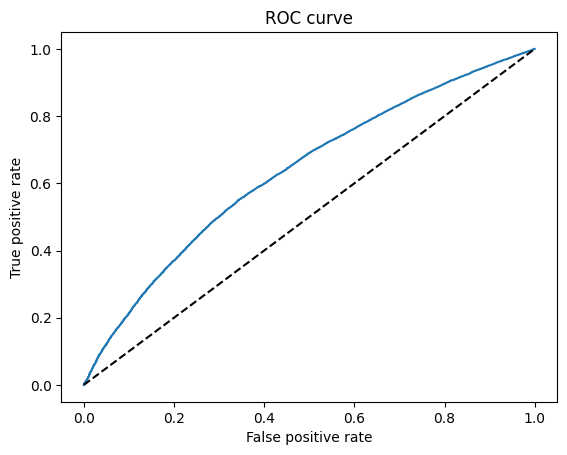

In [46]:
from matplotlib import pyplot as plt

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [47]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.634202556267685

In [48]:
import pickle
pickle.dump(reg_lgd_st_1, open('lgd_model_stage_1.pkl', 'wb'))

In [134]:
import pandas as pd
import numpy as np
lgd_inputs_stage_2_train = pd.read_csv('../loan_data_inputs_train.csv',index_col=0)

In [135]:
lgd_inputs_stage_2_train['recovery_rate'] = lgd_inputs_stage_2_train['recoveries'] / lgd_inputs_stage_2_train['funded_amnt']

In [136]:
lgd_inputs_stage_2_train['recovery_rate'] = np.where(lgd_inputs_stage_2_train['recovery_rate'] > 1, 1, lgd_inputs_stage_2_train['recovery_rate'])
lgd_inputs_stage_2_train['recovery_rate'] = np.where(lgd_inputs_stage_2_train['recovery_rate'] < 0, 0, lgd_inputs_stage_2_train['recovery_rate'])

In [137]:
lgd_inputs_stage_2_train['CCF'] = (lgd_inputs_stage_2_train['funded_amnt'] - lgd_inputs_stage_2_train['total_rec_prncp']) / lgd_inputs_stage_2_train['funded_amnt']

In [138]:
lgd_inputs_stage_2_train['CCF'].describe()

count    373028.000000
mean          0.344757
std           0.327638
min          -0.021734
25%           0.000000
50%           0.347599
75%           0.643666
max           1.000000
Name: CCF, dtype: float64

In [139]:
lgd_inputs_stage_2_train['recovery_rate_0_1'] = np.where(lgd_inputs_stage_2_train['recovery_rate'] == 0, 0, 1)

In [73]:
lgd_stage_2_data = lgd_inputs_stage_2_train[lgd_inputs_stage_2_train['recovery_rate_0_1'] == 1]

In [74]:

from sklearn.model_selection import train_test_split


lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop([ 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [75]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [76]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

class SklearnLinearWithP:
    def __init__(self, *args, **kwargs):
        # Default sklearn LinearRegression
        self.model = LinearRegression(*args, **kwargs)
        self.dropped_columns = {
            "constant_or_zero_variance": [],
            "duplicate": [],
            "near_singular": []
        }

    def _to_dataframe(self, X):
        """Ensure data is pandas DataFrame with column names."""
        if isinstance(X, pd.DataFrame):
            return X.copy()
        elif isinstance(X, pd.Series):
            return X.to_frame()
        else:
            return pd.DataFrame(X, columns=[f"x{i}" for i in range(np.shape(X)[1])])

    def _convert_to_numeric(self, X):
        """Convert all values to numeric (float64), coercing non-numeric to NaN."""
        X = self._to_dataframe(X)
        X = X.apply(pd.to_numeric, errors='coerce')
        X = X.fillna(0)  # Replace NaNs to avoid dtype=object
        return X.astype(float)

    def _clean_X(self, X):
        """Clean input features: remove zero-variance, duplicate, and add constant."""
        X = self._to_dataframe(X)

        # Drop zero variance
        zero_var_cols = X.columns[X.std() == 0].tolist()
        if zero_var_cols:
            self.dropped_columns["constant_or_zero_variance"].extend(zero_var_cols)
            X = X.drop(columns=zero_var_cols, errors='ignore')

        # Drop duplicate columns
        duplicate_cols = X.columns[X.columns.duplicated()].tolist()
        if duplicate_cols:
            self.dropped_columns["duplicate"].extend(duplicate_cols)
            X = X.loc[:, ~X.columns.duplicated()]

        # Add constant
        if 'const' not in X.columns:
            X = sm.add_constant(X, has_constant='add')

        return X

    def fit(self, X, y):
        """Fit sklearn and statsmodels Linear Regression for p-values."""
        X = self._convert_to_numeric(X)
        y = pd.Series(y).astype(float)

        # Fit sklearn model
        self.model.fit(X, y)

        # Prepare for statsmodels
        X_const = self._clean_X(X)
        try:
            sm_model = sm.OLS(y, X_const).fit()
        except np.linalg.LinAlgError:
            # Handle near-singular matrices
            corr_matrix = X_const.corr().abs()
            corr_sum = corr_matrix.sum()
            keep_cols = corr_sum[corr_sum < X_const.shape[1]].index
            dropped_cols = set(X_const.columns) - set(keep_cols)
            X_const = X_const[keep_cols]
            self.dropped_columns["near_singular"] = list(dropped_cols)
            sm_model = sm.OLS(y, X_const).fit()

        # Track final columns
        self.final_columns = list(X_const.columns)

        # Extract statsmodels outputs
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.params = sm_model.params
        self.std_err = sm_model.bse
        self.t_stats = sm_model.tvalues
        self.p_values = sm_model.pvalues
        self.rsq = sm_model.rsquared
        self.adj_rsq = sm_model.rsquared_adj
        self.result = sm_model

        return self
    
    def predict(self, X):
        X = self._convert_to_numeric(X)
        return self.model.predict(X)

    def summary(self):
        """Print the statsmodels regression summary."""
        if hasattr(self, 'result'):
            print(self.result.summary())
        else:
            print("Model not fitted yet. Please call .fit() first.")


In [77]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

In [78]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [79]:
lgd_inputs_stage_2_train.fillna(0, inplace=True)


In [80]:

reg_lgd_st_2 = SklearnLinearWithP()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)


In [81]:
feature_name = lgd_inputs_stage_2_train.columns.values

In [82]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,2.456317e-01
1,grade:A,-7.035812e-02
2,grade:B,-5.231412e-02
3,grade:C,-3.841333e-02
4,grade:D,-3.042767e-02
5,grade:E,-1.495108e-02
6,grade:F,-2.025357e-03
7,home_ownership:MORTGAGE,2.520976e-03
8,home_ownership:NONE,2.151427e-01
9,home_ownership:OTHER,5.128756e-03


In [83]:

p_values = reg_lgd_st_2.p_values
summary_table['p_values'] = summary_table['Feature name'].map(p_values)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.456317e-01,NaN
1,grade:A,-7.035812e-02,1.928947e-10
2,grade:B,-5.231412e-02,4.436115e-09
3,grade:C,-3.841333e-02,4.114882e-07
4,grade:D,-3.042767e-02,3.766349e-06
5,grade:E,-1.495108e-02,1.170049e-02
6,grade:F,-2.025357e-03,7.286749e-01
7,home_ownership:MORTGAGE,2.520976e-03,1.344912e-01
8,home_ownership:NONE,2.151427e-01,2.421359e-06
9,home_ownership:OTHER,5.128756e-03,8.175334e-01


In [84]:
reg_lgd_st_2.dropped_columns

{'constant_or_zero_variance': [], 'duplicate': [], 'near_singular': []}

In [85]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]

In [86]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

In [87]:
lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [88]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [89]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [90]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)

In [91]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.00000,0.29591
0,0.29591,1.00000


<Axes: xlabel='recovery_rate', ylabel='Count'>

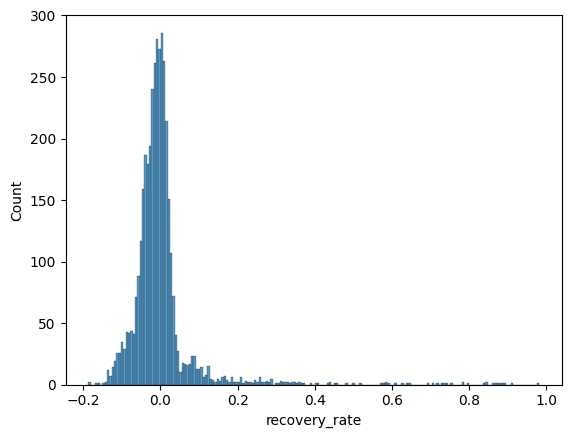

In [92]:
import seaborn as sns
sns.histplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)

In [94]:
import pickle
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.pkl', 'wb'))

In [99]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [100]:
y_hat_test_lgd_stage_2_all

array([0.12897443, 0.16772282, 0.09721457, ..., 0.10733037, 0.09861012,
       0.08950692])

In [127]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [128]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,93257.000000
mean,0.122847
std,0.030374
min,-0.016933
25%,0.106503
50%,0.126139
75%,0.143041
max,0.738174


In [129]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)

In [130]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,93257.000000
mean,0.122849
std,0.030366
min,0.000000
25%,0.106503
50%,0.126139
75%,0.143041
max,0.738174


In [141]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(lgd_inputs_stage_2_train.drop(['recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), lgd_inputs_stage_2_train['CCF'], test_size = 0.2, random_state = 42)

In [142]:
ead_inputs_train.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

In [143]:
ead_inputs_train = ead_inputs_train[features_all]

In [ ]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

In [146]:
ead_inputs_train.fillna(0, inplace=True)

In [147]:
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression()

In [148]:
feature_name = ead_inputs_train.columns.values

In [152]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()

In [154]:

p_values = reg_lgd_st_2.p_values
p_values

const                                   1.407129e-41
grade:A                                 1.928947e-10
grade:B                                 4.436115e-09
grade:C                                 4.114882e-07
grade:D                                 3.766349e-06
grade:E                                 1.170049e-02
grade:F                                 7.286749e-01
home_ownership:MORTGAGE                 1.344912e-01
home_ownership:NONE                     2.421359e-06
home_ownership:OTHER                    8.175334e-01
home_ownership:OWN                      1.227513e-02
verification_status:Not Verified        8.830199e-02
verification_status:Source Verified     1.589582e-01
purpose:car                             9.128117e-01
purpose:debt_consolidation              9.038591e-01
purpose:educational                     6.173172e-02
purpose:home_improvement                7.548542e-01
purpose:house                           8.032579e-01
purpose:major_purchase                  9.5405

In [155]:

summary_table['p_values'] = summary_table['Feature name'].map(p_values)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.139974e+00,NaN
1,grade:A,-5.524467e-01,1.928947e-10
2,grade:B,-4.534127e-01,4.436115e-09
3,grade:C,-3.416702e-01,4.114882e-07
4,grade:D,-2.438029e-01,3.766349e-06
5,grade:E,-1.456336e-01,1.170049e-02
6,grade:F,-5.497806e-02,7.286749e-01
7,home_ownership:MORTGAGE,-1.722550e-02,1.344912e-01
8,home_ownership:NONE,1.065028e-02,2.421359e-06
9,home_ownership:OTHER,1.595042e-01,8.175334e-01


In [156]:
ead_inputs_test = ead_inputs_test[features_all]

In [157]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [ ]:
ead_inputs_test.columns.values

In [160]:
ead_inputs_test.fillna(0, inplace=True)

In [161]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [162]:
ead_targets_test_temp = ead_targets_test

In [163]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [164]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.576234
0,0.576234,1.000000


<Axes: xlabel='CCF', ylabel='Count'>

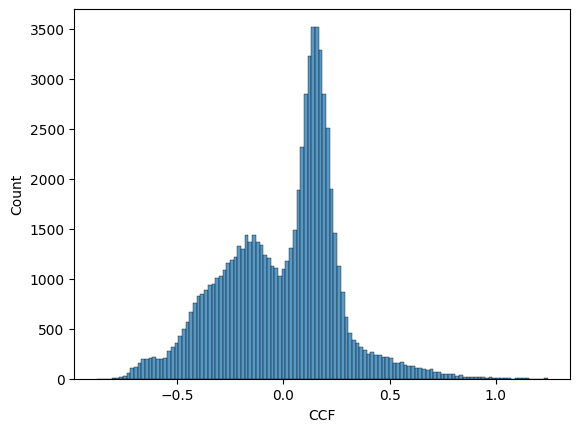

In [165]:
sns.histplot(ead_targets_test - y_hat_test_ead)

In [166]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,74606.000000
mean,0.344512
std,0.192363
min,-0.711537
25%,0.224485
50%,0.347358
75%,0.461847
max,1.141746


In [167]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [168]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,74606.000000
mean,0.349342
std,0.180761
min,0.000000
25%,0.224485
50%,0.347358
75%,0.461847
max,1.000000


In [171]:
loan_data_preprocessed =lgd_stage_2_data

In [172]:
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
# We fill the missing values with zeroes.

/tmp/ipykernel_12646/3236500179.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)


In [173]:
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

/tmp/ipykernel_12646/3996673359.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)


In [174]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]

In [175]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [176]:
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [177]:
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [178]:
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

In [179]:
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [180]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']

In [181]:
loan_data_preprocessed['LGD'].describe()

count    19502.000000
mean         0.892145
std          0.029533
min          0.666844
25%          0.872030
50%          0.891298
75%          0.911018
max          1.000000
Name: LGD, dtype: float64

In [182]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [183]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [184]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']

In [185]:
loan_data_preprocessed['EAD'].describe()

count    19502.000000
mean      4945.464267
std       4772.257949
min          0.000000
25%       1339.073762
50%       3147.451374
75%       7514.851280
max      30478.131494
Name: EAD, dtype: float64

In [187]:
loan_data_inputs_train = pd.read_csv('../loan_data_inputs_train.csv')

In [188]:
loan_data_inputs_test = pd.read_csv('../loan_data_inputs_test.csv')

In [189]:
loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)

In [190]:
loan_data_inputs_pd.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
0,427211,427211,12796369,14818505,24000,24000,24000.0,36 months,8.90,762.08,...,1,0,0,1,0,0,0,0,0,0
1,206088,206088,1439740,1691948,10000,10000,10000.0,36 months,14.33,343.39,...,0,0,0,1,0,0,0,0,0,0
2,136020,136020,5214749,6556909,20425,20425,20425.0,36 months,8.90,648.56,...,0,0,0,1,0,0,0,0,0,0
3,412305,412305,13827698,15890016,17200,17200,17200.0,36 months,16.59,609.73,...,0,0,0,1,0,0,0,0,0,0
4,36159,36159,422455,496525,8400,8400,7450.0,36 months,12.84,282.40,...,0,1,0,1,0,0,0,0,0,0


In [191]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')

In [195]:
features_all_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86']

In [199]:
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [197]:
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]

In [200]:
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [201]:
import pickle

In [202]:
reg_pd = pickle.load(open('pd_model.pkl', 'rb'))

In [203]:
reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

array([0.03094343, 0.11750538, 0.03741927, ..., 0.02790393, 0.04117596,
       0.04646173])

In [204]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0]

In [205]:
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)

In [206]:
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

In [207]:
loan_data_preprocessed_new['EL'].describe()

count    19502.000000
mean       791.139844
std        915.978896
min          0.000000
25%        155.840071
50%        412.680375
75%       1125.675160
max       6713.215952
Name: EL, dtype: float64

In [208]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()


,funded_amnt,funded_amnt,PD,LGD,EAD,EL
36159,8400.0,8400,0.173393,0.926736,1147.312727,184.360633
454638,20000.0,20000,0.051025,0.865737,6308.463182,278.672614
321553,30300.0,30300,0.204966,0.862450,12112.159152,2141.103915
161250,5075.0,5075,0.224737,0.893366,715.532147,143.659168
15109,9725.0,9725,0.288601,0.925807,3095.731323,827.145123


In [209]:
loan_data_preprocessed_new['EL'].sum()

15428809.244872622

In [210]:
loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    2.844667e+08
funded_amnt    6.664052e+09
dtype: float64

In [211]:
loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.054238
funded_amnt    0.002315
dtype: float64